In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../data/retail_sales_dataset.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.columns = df.columns.str.replace(' ', '_')

In [2]:
df.head(10)

,Transaction_ID,Date,Customer_ID,Gender,Age,Product_Category,Quantity,Price_per_Unit,Total_Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100
5,6,2023-04-25,CUST006,Female,45,Beauty,1,30,30
6,7,2023-03-13,CUST007,Male,46,Clothing,2,25,50
7,8,2023-02-22,CUST008,Male,30,Electronics,4,25,100
8,9,2023-12-13,CUST009,Male,63,Electronics,2,300,600
9,10,2023-10-07,CUST010,Female,52,Clothing,4,50,200


In [3]:
daily_sales = (
    df.groupby(df['Date'].dt.date)['Total_Amount']
    .sum()
    .reset_index()
)

daily_sales.columns = ['Date', 'Total_Amount']
daily_sales.head()


,Date,Total_Amount
0,2023-01-01,3600
1,2023-01-02,1765
2,2023-01-03,600
3,2023-01-04,1240
4,2023-01-05,1100


In [4]:
window = 7  # 7-day rolling window

daily_sales['Rolling_Mean'] = daily_sales['Total_Amount'].rolling(window).mean()
daily_sales['Rolling_Std'] = daily_sales['Total_Amount'].rolling(window).std()


In [5]:
daily_sales['Z_Score'] = (
    (daily_sales['Total_Amount'] - daily_sales['Rolling_Mean']) 
    / daily_sales['Rolling_Std']
)

daily_sales.head(10)


,Date,Total_Amount,Rolling_Mean,Rolling_Std,Z_Score
0,2023-01-01,3600,NaN,NaN,NaN
1,2023-01-02,1765,NaN,NaN,NaN
2,2023-01-03,600,NaN,NaN,NaN
3,2023-01-04,1240,NaN,NaN,NaN
4,2023-01-05,1100,NaN,NaN,NaN
5,2023-01-06,620,NaN,NaN,NaN
6,2023-01-07,150,1296.428571,1141.974585,-1.003900
7,2023-01-08,625,871.428571,533.015903,-0.462329
8,2023-01-09,200,647.857143,409.693556,-1.093152
9,2023-01-10,230,595.000000,439.668436,-0.830171


In [6]:
threshold = 2  # standard practice

daily_sales['Anomaly'] = daily_sales['Z_Score'].abs() > threshold
daily_sales[daily_sales['Anomaly'] == True]


,Date,Total_Amount,Rolling_Mean,Rolling_Std,Z_Score,Anomaly
11,2023-01-13,1930,576.428571,628.203220,2.154671,True
62,2023-03-07,3040,973.571429,950.108390,2.174940,True
85,2023-04-01,4400,1201.428571,1492.229077,2.143486,True
119,2023-05-08,4200,1330.000000,1351.237088,2.123980,True
127,2023-05-16,7260,1875.714286,2500.545655,2.153244,True
134,2023-05-23,8455,2691.428571,2720.898617,2.118260,True
161,2023-06-19,2945,1020.714286,953.399307,2.018342,True
166,2023-06-24,6220,1688.571429,2228.472411,2.033424,True
183,2023-07-14,5125,1180.000000,1907.500546,2.068151,True
203,2023-08-05,5205,1197.142857,1830.846473,2.189073,True


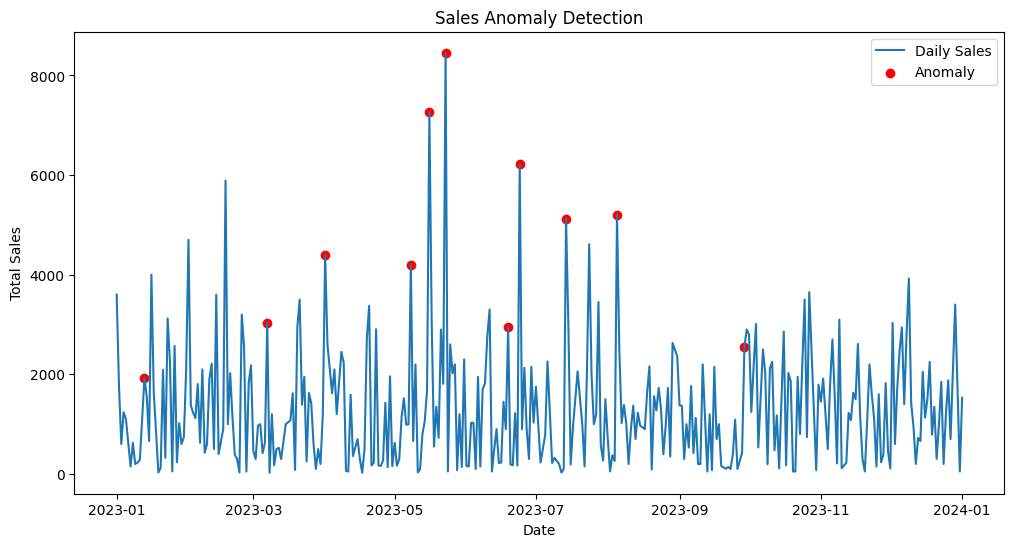

In [7]:
plt.figure(figsize=(12,6))
plt.plot(daily_sales['Date'], daily_sales['Total_Amount'], label='Daily Sales')
plt.scatter(
    daily_sales[daily_sales['Anomaly']]['Date'],
    daily_sales[daily_sales['Anomaly']]['Total_Amount'],
    color='red',
    label='Anomaly'
)
plt.legend()
plt.title("Sales Anomaly Detection")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.show()


## What caused spikes or drops?
_Multiple anomalies occurring within a short period may indicate instability in demand, pricing errors, or supply chain disruptions._


In [8]:
category_daily = (
    df.groupby([df['Date'].dt.date, 'Product_Category'])['Total_Amount']
    .sum()
    .reset_index()
)

category_daily.columns = ['Date', 'Product_Category', 'Total_Amount']
category_daily.head()

,Date,Product_Category,Total_Amount
0,2023-01-01,Beauty,1500
1,2023-01-01,Clothing,2100
2,2023-01-02,Beauty,25
3,2023-01-02,Clothing,1650
4,2023-01-02,Electronics,90


In [9]:
category_daily['Rolling_Mean'] = (
    category_daily
    .groupby('Product_Category')['Total_Amount']
    .transform(lambda x: x.rolling(7).mean())
)

category_daily['Rolling_Std'] = (
    category_daily
    .groupby('Product_Category')['Total_Amount']
    .transform(lambda x: x.rolling(7).std())
)


In [10]:
category_daily['Z_Score'] = (
    (category_daily['Total_Amount'] - category_daily['Rolling_Mean'])
    / category_daily['Rolling_Std']
)

category_daily['Anomaly'] = category_daily['Z_Score'].abs() > 2


In [11]:
category_daily[category_daily['Anomaly'] == True]\
    .sort_values('Z_Score', ascending=False)


,Date,Product_Category,Total_Amount,Rolling_Mean,Rolling_Std,Z_Score,Anomaly
226,2023-05-05,Electronics,1400,252.142857,506.506475,2.266224,True
624,2023-12-15,Beauty,2000,376.428571,716.825841,2.264945,True
456,2023-09-16,Electronics,2100,404.285714,750.752004,2.258688,True
205,2023-04-27,Clothing,1200,299.285714,399.191146,2.256348,True
351,2023-07-14,Electronics,1110,270.000000,377.270902,2.226517,True
387,2023-08-05,Electronics,2530,611.428571,874.903396,2.192895,True
332,2023-06-30,Clothing,1030,258.571429,352.263092,2.189922,True
564,2023-11-15,Electronics,1600,370.000000,563.375245,2.183270,True
53,2023-02-01,Clothing,3500,897.142857,1200.412627,2.168302,True
324,2023-06-24,Electronics,5200,1125.714286,1882.054349,2.164808,True


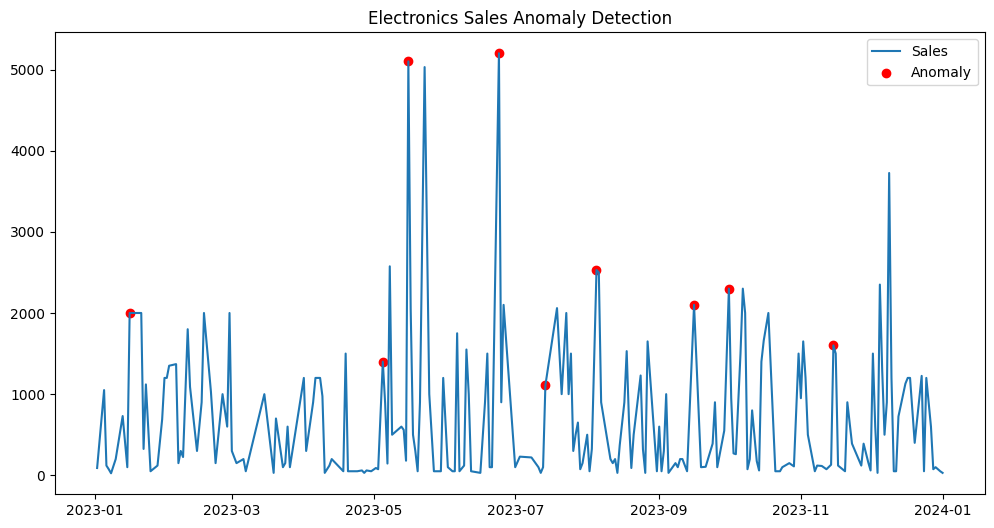

In [12]:
cat = 'Electronics'
subset = category_daily[category_daily['Product_Category'] == cat]

plt.figure(figsize=(12,6))
plt.plot(subset['Date'], subset['Total_Amount'], label='Sales')
plt.scatter(
    subset[subset['Anomaly']]['Date'],
    subset[subset['Anomaly']]['Total_Amount'],
    color='red',
    label='Anomaly'
)
plt.title(f"{cat} Sales Anomaly Detection")
plt.legend()
plt.show()


In [13]:
features = category_daily[[
    'Total_Amount',
    'Rolling_Mean',
    'Rolling_Std'
]].dropna()


In [14]:
category_daily['Pct_Change'] = category_daily['Total_Amount'].pct_change()


In [15]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42
)

category_daily.loc[features.index, 'IF_Anomaly'] = iso.fit_predict(features)
category_daily['IF_Anomaly'] = category_daily['IF_Anomaly'] == -1
